#imports e divisões

In [ ]:
!pip install pydicom

import os
import shutil
import pydicom
import numpy as np
from PIL import Image

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Rescaling
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.utils import image_dataset_from_directory

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 6.0 MB/s 


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d pedroamaro/rsana-test-ds
!unzip /content/rsana-test-ds.zip
!rm /content/rsana-test-ds.zip

In [ ]:
!mkdir /content/test
!mkdir /content/test/no
!mkdir /content/test/yes

!mkdir /content/train
!mkdir /content/train/no
!mkdir /content/train/yes

In [ ]:
!mkdir ds_jpg
!mkdir /content/ds_jpg/no
!mkdir /content/ds_jpg/yes

In [ ]:
def window_image(img, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def save_brainW_as_jpg(path, id, dest_folder):
  dcm = pydicom.dcmread(path)
  
  sample = dcm.pixel_array.astype(float) * dcm.RescaleSlope + dcm.RescaleIntercept

  im = window_image(sample, 40, 80)

  rescaled_im = (np.maximum(im, 0)/im.max())*255.0
  final_im = np.uint8(rescaled_im)

  final_im = Image.fromarray(final_im)
  final_im.save(dest_folder+id+'.jpg')

In [ ]:
train_path = "/content/small_rsna_ds/yes/"
folder = os.listdir("/content/small_rsna_ds/yes/")
dest_folder = "/content/ds_jpg/yes/"

for id_ in folder:
  img_id = id_[:12]
  save_brainW_as_jpg(train_path + f"{id_}", img_id, dest_folder)

In [ ]:
train_path = "/content/small_rsna_ds/no/"
folder = os.listdir("/content/small_rsna_ds/no/")
dest_folder = "/content/ds_jpg/no/"

for id_ in folder:
  img_id = id_[:12]
  save_brainW_as_jpg(train_path + f"{id_}", img_id, dest_folder)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [ ]:
print('Numero de imagens: NO')
!ls /content/ds_jpg/no/ | wc -l
print('Numero de imagens: YES')
!ls /content/ds_jpg/yes/ | wc -l

Numero de imagens: NO
117
Numero de imagens: YES
32


In [ ]:
cont = 0
for file in os.listdir('/content/ds_jpg/yes'):
  if cont <= 10:
    shutil.copy('/content/ds_jpg/yes/' + file, '/content/test/yes')
  else:
      shutil.copy('/content/ds_jpg/yes/' + file, '/content/train/yes')
  cont+=1

In [ ]:
cont = 0
for file in os.listdir('/content/ds_jpg/no'):
  if cont <= 35:
    shutil.copy('/content/ds_jpg/no/' + file, '/content/test/no')
  else:
      shutil.copy('/content/ds_jpg/no/' + file, '/content/train/no')
  cont+=1

In [ ]:
print('Numero de imagens: NO')
!ls /content/train/no | wc -l
print('Numero de imagens: YES')
!ls /content/train/yes | wc -l

print('Numero de imagens: NO')
!ls /content/test/no | wc -l
print('Numero de imagens: YES')
!ls /content/test/yes | wc -l

Numero de imagens: NO
81
Numero de imagens: YES
21
Numero de imagens: NO
36
Numero de imagens: YES
11


#Modelo train

In [ ]:
train_data = image_dataset_from_directory(
    "/content/train",
     labels='inferred',
     validation_split=0.25,
     subset="training",
     seed=123,
     batch_size = 64,
     color_mode = "grayscale"
     )

Found 102 files belonging to 2 classes.
Using 77 files for training.


In [ ]:
val_data = image_dataset_from_directory(
    "/content/train",
     labels='inferred',
     validation_split=0.25,
     subset="validation",
     seed=123,
     batch_size = 64,
     color_mode = "grayscale"
)

Found 102 files belonging to 2 classes.
Using 25 files for validation.


In [ ]:
class_names = train_data.class_names

In [ ]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 256, 256, 1)
(64,)


In [ ]:
normalization_layer = Rescaling(1./255)

normalized_data = train_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_data))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
keras.backend.clear_session()

In [ ]:
ins = image_batch.shape[1:]

model = Sequential()

model.add(Conv2D(32, (3,3), padding="same", activation="relu", input_shape=ins))

model.add(Conv2D(32, (3,3), padding="same", strides = (2,2), activation="relu"))

model.add(Conv2D(64, (3,3), padding="same", strides = (2,2), activation="relu"))

model.add(Dropout(0.2))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dense(128, activation="relu"))

model.add(Flatten())

model.add(Dense(1024, activation="relu"))

model.add(Dropout(0.5))

model.add(Dense(1024, activation="relu"))

model.add(Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 dense (Dense)               (None, 32, 32, 128)       8320      
                                                        

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.00001), metrics=[keras.metrics.AUC(), 'accuracy'])

In [ ]:
run_hist = model.fit(train_data, validation_data=val_data, epochs=10)

Epoch 1/10
2/2 [==============================] - 12s 3s/step - loss: 1.3388 - auc: 0.5856 - accuracy: 0.6234 - val_loss: 3.5660 - val_auc: 0.4444 - val_accuracy: 0.7200
Epoch 2/10
2/2 [==============================] - 8s 3s/step - loss: 2.0851 - auc: 0.5641 - accuracy: 0.8182 - val_loss: 0.7217 - val_auc: 0.8016 - val_accuracy: 0.8400
Epoch 3/10
2/2 [==============================] - 8s 3s/step - loss: 0.8071 - auc: 0.7540 - accuracy: 0.8831 - val_loss: 1.2866 - val_auc: 0.8730 - val_accuracy: 0.5600
Epoch 4/10
2/2 [==============================] - 8s 3s/step - loss: 0.6281 - auc: 0.9246 - accuracy: 0.7532 - val_loss: 0.6667 - val_auc: 0.7976 - val_accuracy: 0.7200
Epoch 5/10
2/2 [==============================] - 8s 3s/step - loss: 0.2796 - auc: 0.9325 - accuracy: 0.9481 - val_loss: 1.4066 - val_auc: 0.6786 - val_accuracy: 0.8000
Epoch 6/10
2/2 [==============================] - 8s 3s/step - loss: 0.2713 - auc: 0.9484 - accuracy: 0.9091 - val_loss: 1.9096 - val_auc: 0.6746 - val_ac

# Evalueate

In [ ]:
test_data = image_dataset_from_directory(
    "/content/test",
     labels='inferred',
     label_mode="int",
     batch_size = 64,
     color_mode = "grayscale"
     )

Found 47 files belonging to 2 classes.


In [ ]:
results = model.evaluate(test_data)
print(results)

1/1 [==============================] - 1s 1s/step - loss: 2.0144 - auc: 0.5480 - accuracy: 0.5319
[2.0144248008728027, 0.5479798316955566, 0.5319148898124695]


#Predict

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score

In [ ]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {}'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])

In [ ]:
test_data = image_dataset_from_directory(
    "/content/test",
     labels='inferred',
     label_mode="int",
     batch_size = 64,
     color_mode = "grayscale"
     )

Found 47 files belonging to 2 classes.


In [ ]:
for x, y in test_data:
  y_test = y

In [ ]:
y_test

<tf.Tensor: shape=(47,), dtype=int32, numpy=
array([0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int32)>

In [ ]:
y_hat = model.predict(test_data)
y_hat

array([[7.9317391e-03],
       [1.9508302e-02],
       [1.4111036e-07],
       [8.2547069e-02],
       [6.0770929e-02],
       [1.2920358e-07],
       [5.2852027e-08],
       [6.3120948e-05],
       [4.9092770e-03],
       [1.1950565e-05],
       [2.7953859e-06],
       [1.7440319e-04],
       [6.4217734e-06],
       [3.4448345e-05],
       [6.0623288e-03],
       [6.5588951e-04],
       [3.5038590e-04],
       [5.5182689e-01],
       [1.0493064e-05],
       [7.8323483e-04],
       [3.7386626e-02],
       [3.4717685e-01],
       [2.5032103e-02],
       [5.2490830e-04],
       [2.1356419e-01],
       [1.7447829e-02],
       [9.9235761e-01],
       [8.4573710e-01],
       [1.4030294e-07],
       [9.9240273e-01],
       [9.4450748e-01],
       [1.9893212e-08],
       [8.8362056e-01],
       [1.3217993e-07],
       [1.5534839e-08],
       [5.1394131e-06],
       [7.8164339e-03],
       [6.5715947e-05],
       [6.1881429e-01],
       [1.5305266e-05],
       [1.9927621e-03],
       [6.976411

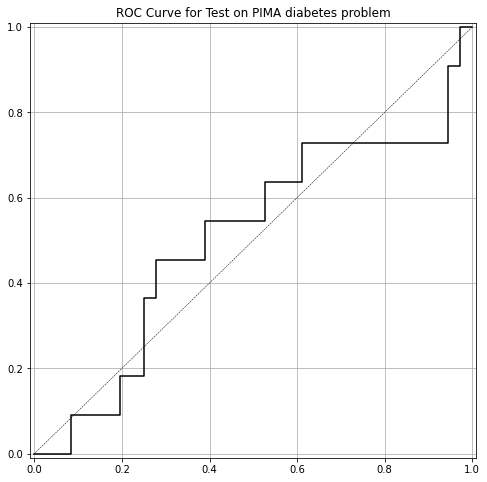

In [ ]:
plot_roc(y_test, y_hat, "Test")